# IELTS Score Prediction

***11月完成工作***<br>
* <b>特征构造：</b>引入词汇丰富度、主动/被动语态、指代使用、过渡句、情态动词使用、可读性指数计算；<br>
* <b>可解释性：</b>引入Trusted ML进行可解释性分析；<br>
* <b>词汇资源：</b>通过词向量分布，判断词汇使用稀有程度；<br>
* <b>作文切割：</b>bert-base会对过长文本进行截断，考虑分段切割；<br>
* <b>任务响应：</b>使用摘要提取计算similarity。<br>

***TODO：***<br>
* <b>1、生成写作评价模版：</b>
* （1）TR：设置similarity阈值，预训练模型零样本分类
* （2）LR：高级词汇、同义词替换（尝试导入雅思高级词汇表）
* （3）CC：基于目前构造的特征，考虑如何评估每个段落的衔接情况
* （4）GA：目前统计到的语法和拼写错误，并给出修正建议

* 2、<b>shap和lime</b>对单个样本的评估结果的解释性，在评价中着重标注影响较大的变量

* 3、整合模型代码，形成pipeline

In [1]:
# 导入模块
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import pickle

import warnings
warnings.filterwarnings('ignore')

### 数据预处理

In [2]:
text = pd.read_csv("data.csv")
text.head()

,problem,article,subParagraph,TR,CC,LR,GA,score
0,Some children spend hours every day on their s...,"In contemporary society, it is a common sight ...",4,9.0,9.0,8.5,9.0,9.0
1,Some children spend hours every day on their s...,The ubiquitous presence of smartphones has pro...,5,9.0,9.0,8.5,9.0,9.0
2,Some children spend hours every day on their s...,The proliferation of pocket-sized electronics ...,5,9.0,9.0,9.0,9.0,9.0
3,Some children spend hours every day on their s...,The phenomenon of children spending extensive ...,5,9.0,9.0,9.0,9.0,9.0
4,Some children spend hours every day on their s...,"In the contemporary era, the proliferation of ...",5,7.0,7.0,8.0,8.0,7.5


In [3]:
len(text)

33047

In [ ]:
# 清除重复样本
text_unique = text.drop_duplicates(subset='article', keep='first').reset_index(drop=True)
text_unique

### 特征工程

#### 提取文章摘要

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("./sshleifer/distilbart-cnn-12-6")
model = AutoModelForSeq2SeqLM.from_pretrained("./sshleifer/distilbart-cnn-12-6").to(device)
model.eval()

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# 分批次处理
article = text['article'].tolist()
dataset = TextDataset(article)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# 生成摘要，词数80~100
def generate_summaries(batch):
    inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=100, min_length=80)
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [2]:
tmp = []
cnt = 0
print("***** start process *****")

for batch in data_loader:
    if cnt > 0 and cnt % 128 == 0:
        print("Process ", cnt, " texts.")
    summaries = generate_summaries(batch)
    tmp.extend(summaries)
    cnt += 32
print("***** finish process *****")

text['summary'] = tmp
text.head()

,problem,article,subParagraph,TR,CC,LR,GA,score,upper,spelling_errors,...,pronouns,cohesion,passive_ratio,modal_verbs_usage,Flesch_Kincaid_score,Gunning_Fog_score,SMOG_score,metaphor,grammar_error,summary
0,Some children spend hours every day on their s...,"In contemporary society, it is a common sight ...",4,9.0,9.0,8.5,9.0,9.0,0,2,...,10,1,0.583333,7,14.3,16.57,15.8,0,0,Young people spend a considerable amount of t...
1,Some children spend hours every day on their s...,The ubiquitous presence of smartphones has pro...,5,9.0,9.0,8.5,9.0,9.0,0,2,...,9,3,0.705882,10,13.3,15.27,14.8,1,0,Many children dedicate a significant portion ...
2,Some children spend hours every day on their s...,The proliferation of pocket-sized electronics ...,5,9.0,9.0,9.0,9.0,9.0,0,5,...,13,3,0.375000,5,15.8,17.56,17.1,2,0,The proliferation of pocket-sized electronics...
3,Some children spend hours every day on their s...,The phenomenon of children spending extensive ...,5,9.0,9.0,9.0,9.0,9.0,0,4,...,7,3,0.578947,6,14.2,16.69,16.0,0,0,The phenomenon of children spending extensive...
4,Some children spend hours every day on their s...,"In the contemporary era, the proliferation of ...",5,7.0,7.0,8.0,8.0,7.5,0,2,...,13,4,0.529412,4,15.6,16.50,16.6,0,0,"In the modern era, smartphones have become in..."


In [ ]:
from transformers import pipeline

# 零样本分类模型
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
labels = ["完美地回答了问题", "比较好地响应题目", "只回答了部分问题", "没有响应问题"]
label_to_score = {"完美地回答了问题": 4, 
                  "比较好地响应题目": 3, 
                  "只回答了部分问题": 2, 
                  "没有响应问题":1}
# 输入作文
def TR_classification(problem, article):
    prompt = f''' 
                请你评估以下雅思写作Task2的文章的任务主题响应程度，划分类别为：
                完美地回答了问题、比较好地响应题目、只回答了部分问题、没有响应问题。
                题目为：{problem}, 
                文章为：{article}
             '''
    result = classifier(prompt, candidate_labels=labels)

    # 分类结果
    label = label_to_score[result['labels'][0]]
    score = label * result['score'][0]
    
    return label, score


#### 词向量分布统计

In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

# text_list = text['article'].to_list()
text_list = [text['article'][0]]

def preprocess_text(text):
    text = text.lower()

    text = ''.join([char for char in text if char not in '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'])
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

texts = [preprocess_text(text) for text in text_list]

In [17]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

# 训练Word2Vec模型
model = Word2Vec(texts, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

def calculate_rarity(word, top_n=10):
    word_vector = word_vectors[word]
    similarities = [(word_vectors[other_word], other_word) for other_word in word_vectors.index_to_key]
    similarities.sort(key=lambda x: x[0].dot(word_vector) / (np.linalg.norm(x[0]) * np.linalg.norm(word_vector)), reverse=True)
    return similarities[1:top_n+1]

In [18]:
def calculate_cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)

threshold = 0.5

# 识别高级词汇
res = []
advanced_words = []
for word in word_vectors.index_to_key:
    top_similar_words = calculate_rarity(word)
    t = [calculate_cosine_similarity(word_vectors[word], sim_vector)  for sim_vector, _ in top_similar_words]
    res.append(max(t))
    if all(calculate_cosine_similarity(word_vectors[word], sim_vector) < threshold for sim_vector, _ in top_similar_words):
        advanced_words.append(word)

print(np.mean(res), np.max(res), np.min(res))
print("Advanced words:", advanced_words[:5])

0.26070297 0.37004676 0.17201765
Advanced words: ['physical', 'smartphones', 'use', 'smartphone', 'young']


In [8]:
advanced_words

['’',
 'without',
 'personal',
 'fact',
 'means',
 'far',
 'continue',
 'clearly',
 'reality',
 'ordinary',
 'movement',
 'necessarily',
 'stream',
 'timing',
 'conceptions',
 'wisest',
 'environmentwhile',
 'materially',
 'handicraft',
 'assertiveness',
 'communicational',
 'modren',
 'aimless',
 'conclusionmany',
 'careershowever',
 'itdespite',
 'lifestylethe',
 'explication',
 'advantaged',
 'arteries',
 'fact-based',
 'allied',
 'armchair',
 'relaxedit',
 'diffusion',
 'interfered',
 'sportmen',
 'jobsthe',
 'strings',
 'bountiful',
 'peoplepeople',
 'panama',
 'orphanage',
 'lateness',
 '„',
 'liberating',
 'countriesi',
 'groupdespite',
 'educationanother',
 'shunning',
 'unchallenged',
 'space-related',
 'bravely',
 'unsafety',
 'spieces',
 'demandson',
 'moisture',
 'quantitatively',
 'precedents',
 'deceit',
 'itdue',
 'educationand',
 'endeavorto',
 'belowmusic',
 'commissioning',
 'preconditions',
 'appetizing',
 'harmonized',
 'optimistically',
 'detectors',
 'suicideon',


效果不好，找不到高级词汇，计算非常耗时，下一阶段准备尝试导入雅思高级词汇库。

#### 逆文档频率IDF搜索高级词汇

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker

documents = text['article'].tolist()
spell = SpellChecker()

# 使用TfidfVectorizer提取词频特征
vectorizer = TfidfVectorizer(stop_words='english')  # 移除常见的停用词
X = vectorizer.fit_transform(documents)

# 获取所有的词汇和它们的IDF值，出现次数少可以近似看作使用了高级词汇
idf_scores = vectorizer.idf_

words = np.array(vectorizer.get_feature_names_out())

def check(word):
    corrected = spell.correction(word)
    if word != corrected:
        return False
    for i in range(10):
        if str(i) in word:
            return False
    return True

# 开始统计高级词汇
threshold_idf = 5
important_words = []

for word, idf in zip(words, idf_scores):
    if check(word) and idf > threshold_idf:
        important_words.append((word, idf))
important_words.sort(key= lambda x: x[1], reverse=True)

with open("ielts_dictionary.pkl", "wb") as f:
    pickle.dump(important_words, f)

In [ ]:
with open("ielts_dictionary.pkl", "rb") as f:
    loaded_list = pickle.load(f)

outliers = ['boys','bought','dishes','relaxing','sit','testing','characters','discovery', 'entering','knowledgeable','nearby','bags',
            'carrying','debt','drink','hunting','targeted','gave']

important_words = []
score_dict = {}
for x in loaded_list:
    if x[1] > 5 and x[0] not in outliers:
        important_words.append(x[0])
        score_dict[x[0]] = x[1]

#### 四维度特征构造

In [23]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [5]:
def count_capitalization_errors(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    upper_count = 0
    for sentence in sentences:
        stripped_sentence = sentence.strip()
        if stripped_sentence:
            if not stripped_sentence[0].isupper():
                upper_count += 1
                
    return upper_count

text['upper'] = text['article'].apply(count_capitalization_errors)

text[text.upper > 0]

,problem,article,subParagraph,TR,CC,LR,GA,score,upper
9,Some children spend hours every day on their s...,"In today’s digital era, children devote an eno...",5,7.0,6.0,6.0,7.0,6.5,1
11,Some children spend hours every day on their s...,Some of the juveniles are mostly occupied duri...,4,6.0,5.0,5.0,6.0,5.5,1
35,Some children spend hours every day on their s...,technology has flourished through leaps and bo...,7,5.0,4.0,4.0,4.0,4.5,12
61,Some people think that all university students...,Some people suggest that college students shou...,4,6.0,5.0,5.0,5.0,5.5,22
77,"In many countries nowadays, consumers can go t...","Today, many people can buy special food which ...",4,6.0,4.5,5.5,4.5,5.0,1
...,...,...,...,...,...,...,...,...,...
32972,Some believe that people have no interest in m...,It is believed that these days there is no att...,4,5.0,4.0,4.0,4.0,4.5,1
32974,"In the urban world, the architectural design a...",Given the exponential emergence of many metrop...,5,7.5,7.5,7.5,7.5,7.5,2
32980,Some people believe that the internet has brou...,a majority of people think that the individual...,4,5.5,5.0,5.5,3.5,5.0,2
33025,Some people think that competitive sports have...,"According to some people, competitive sports h...",4,5.5,4.5,5.0,3.0,4.5,1


In [6]:
import spacy
from collections import Counter
from spellchecker import SpellChecker
from nltk.tokenize import sent_tokenize

nlp = spacy.load("en_core_web_sm")

def determine_expected_tense(tokens):
    """根据句子中的时间词确定期望的时态"""
    for token in tokens:
        if token.dep_ == "nsubj":  # 找到主语
            if any(time_word in token.text.lower() for time_word in ["yesterday", "last week", "ago", "since","in the past", "last month", "last year", "the other day"]):
                return "past"
            elif any(time_word in token.text.lower() for time_word in ["now", "always", "every", "usually", "often", "sometimes"]):
                return "present"
            elif any(time_word in token.text.lower() for time_word in ["tomorrow", "next", "in the future"]):
                return "future"
    return "unknown"

def is_correct_tense(token, expected_tense):
    """检查动词时态是否符合预期"""
    if expected_tense == "past":
        return token.tag_ in ["VBD", "VBN"]  # 过去时和过去分词
    elif expected_tense == "present":
        return token.tag_ in ["VB", "VBZ", "VBG"]  # 现在时
    elif expected_tense == "future":
        return token.dep_ == "aux" and token.lemma_ == "will"  # 将来时
    return True

def check_tense_errors(sentence):
    """检查句子中的时态错误"""
    tokens = nlp(sentence)  # 使用 spaCy 解析句子
    tense_errors = 0
    expected_tense = determine_expected_tense(tokens)
    
    for token in tokens:
        if token.dep_ == "ROOT":  # 找到句子的主要动词
            if not is_correct_tense(token, expected_tense):
                tense_errors += 1
    return tense_errors


In [ ]:
# 拼写错误检测
spell = SpellChecker()
def spell_check(text):
    doc = nlp(text)
    misspelled = spell.unknown([token.text for token in doc if token.is_alpha])  # 仅检查字母字符
    return len(misspelled)

# 检查时态错误
def tense_error_check(text):
    sentences = sent_tokenize(text)
    total_errors = 0
    for sentence in sentences:
        errors = check_tense_errors(sentence)
        total_errors += errors
    
    return total_errors

# 检查单复数使用错误
def plural_error_check(doc):
    errors = 0
    for token in doc:
        if token.dep_ == 'nsubj' and token.tag_ == 'NN':  # 单数名词
            for child in token.children:
                if child.dep_ == 'ROOT':
                    if child.tag_ != 'VBZ':  # 单数主语应配合单三形式
                        errors += 1
        
        elif token.dep_ == 'nsubj' and token.tag_ == 'NNS':  # 复数名词
            for child in token.children:
                if child.dep_ == 'ROOT':
                    if child.tag_ == 'VBZ':  # 复数主语不应使用单三形式
                        errors += 1
    return errors

# 句型统计
def sentence_type_statistics(doc):
    simple = 0
    conj = 0
    clause1 = 0
    clause2 = 0
    for sent in doc.sents:
        tokens = [token for token in sent]
        # 统计主语、谓语、连词、从句数量
        subjects = [token for token in tokens if token.dep_ == 'nsubj']
        predicates = [token for token in tokens if token.dep_ == 'ROOT']
        conjunctions = [token for token in tokens if token.dep_ == 'cc']
        ccomp = [token for token in tokens if token.dep_ == 'ccomp']
        acl = [token for token in tokens if token.dep_ == 'acl']
        
        if len(subjects) > 0 and len(predicates) > 0:
            if len(subjects) == 1 and len(predicates) == 1 and len(ccomp) + len(acl) == 0:
                simple += 1  # 简单句
            if len(conjunctions) > 0:
                conj += 1
            if len(ccomp) > 0:
                clause1 += 1
            if len(acl) > 0:
                clause2 += 1
    return simple,conj,clause1,clause2


In [97]:
import language_tool_python
from spellchecker import SpellChecker
import string

# 初始化语言工具和拼写检查器
tool = language_tool_python.LanguageTool('en-US')
spell = SpellChecker()

def check_grammar(text):
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
    translation_table = str.maketrans(punct, ' ' * len(punct))
    punct_text = text.translate(translation_table)

    # 拼写错误
    spelling_errors = {}
    words = punct_text.split()
    for word in words:
        if word not in spell:
            corrected = spell.candidates(word)

            if corrected is None:
                spelling_errors[word] = None
            else:
                spelling_errors[word] = list(corrected)  # 获取拼写建议

    # 检查语法错误
    grammar_matches = tool.check(text)
    grammar_errors = []
    
    for match in grammar_matches:
        if match.ruleId in ['MORFOLOGIK_RULE_EN_US', 'WHITESPACE_RULE','CONSECUTIVE_SPACES', 'UPPERCASE_SENTENCE_START']:
            continue

        error_info = {
            'error_text': match.context,  # 错误上下文
            'error_type': match.ruleId,  # 错误类型
            'suggestions': match.replacements,  # 建议替换
            'error_position': (match.offset, match.errorLength)  # 错误位置
        }
        grammar_errors.append(error_info)

    return {
        'spelling_errors': spelling_errors,
        'grammar_errors': grammar_errors
    }

'''
常见 error_type 列表


MORFOLOGIK_RULE_EN_US: 使用 Morphologic 规则进行的拼写检查，通常用于检测英语中的拼写错误。

EN_CONTRACTION: 检查不恰当或缺失的缩写形式，例如 "cannot" 应该写成 "can't"。

SUBJECT_VERB_AGREEMENT: 主谓一致性错误，例如 "They is" 应改为 "They are"。

PLURAL_CHECK: 复数形式错误，例如 "childs" 应该是 "children"。

UNNECESSARY_COMMA: 多余的逗号，例如在不需要逗号的地方使用了逗号。

TENSE: 时态不一致，例如在同一句子中混用了过去和现在时。

WORD_REPEATED: 重复的单词，例如 "the the book"。

PASSIVE_VOICE: 被动语态使用不当，或建议使用主动语态。

FRAGMENT: 句子片段，没有完整的主语或谓语。

UNCLEAR_PRONOUN: 不明确的代词，例如使用 "it" 时不清楚指代的对象。

COLLOQUIALISM: 口语化表达在正式写作中使用不当。

USELESS_WORDS: 使用多余或不必要的词。

ADVERB: 副词使用不当或位置错误。

CONJUNCTION: 连词使用错误
 '''

'\n常见 error_type 列表\n\n\nMORFOLOGIK_RULE_EN_US: 使用 Morphologic 规则进行的拼写检查，通常用于检测英语中的拼写错误。\n\nEN_CONTRACTION: 检查不恰当或缺失的缩写形式，例如 "cannot" 应该写成 "can\'t"。\n\nSUBJECT_VERB_AGREEMENT: 主谓一致性错误，例如 "They is" 应改为 "They are"。\n\nPLURAL_CHECK: 复数形式错误，例如 "childs" 应该是 "children"。\n\nUNNECESSARY_COMMA: 多余的逗号，例如在不需要逗号的地方使用了逗号。\n\nTENSE: 时态不一致，例如在同一句子中混用了过去和现在时。\n\nWORD_REPEATED: 重复的单词，例如 "the the book"。\n\nPASSIVE_VOICE: 被动语态使用不当，或建议使用主动语态。\n\nFRAGMENT: 句子片段，没有完整的主语或谓语。\n\nUNCLEAR_PRONOUN: 不明确的代词，例如使用 "it" 时不清楚指代的对象。\n\nCOLLOQUIALISM: 口语化表达在正式写作中使用不当。\n\nUSELESS_WORDS: 使用多余或不必要的词。\n\nADVERB: 副词使用不当或位置错误。\n\nCONJUNCTION: 连词使用错误\n '

In [ ]:
from nltk import sent_tokenize, word_tokenize, pos_tag
import textstat

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# 词汇多样性
def TTR(words):
    num_words = len(words)
    unique_words = len(set(words))
    ttr = unique_words / num_words if num_words > 0 else 0  # 类型-令词比
    return ttr

# 句子结构
def sentence_complexity(sentences, words):
    num_sentences = len(sentences)
    avg_sentence_length = len(words) / num_sentences if num_sentences > 0 else 0
    longest_sentence = max(len(word_tokenize(sentence)) for sentence in sentences) if sentences else 0
    shortest_sentence = min(len(word_tokenize(sentence)) for sentence in sentences) if sentences else 0

    # 复杂句与简单句比例
    complex_sentences = sum(1 for sentence in sentences if any(pos.startswith('IN') for _, pos in pos_tag(word_tokenize(sentence))))
    complex_simple_ratio = complex_sentences / num_sentences if num_sentences > 0 else 0

    return avg_sentence_length, longest_sentence, shortest_sentence, complex_simple_ratio

# 检查指代使用情况
def pronoun_usage(text):
    pronouns = re.findall(r'\b(I|you|he|she|it|we|they|my|your|his|her|its|our|their)\b', text, re.IGNORECASE)
    return len(pronouns)

# 检查段落衔接与过渡句
def cohesion_analysis(text):
    transitions = ['however', 'moreover', 'furthermore', 'in addition', 'therefore', 'consequently']
    transition_count = sum(text.lower().count(t) for t in transitions)
    return transition_count

# 主动语态与被动语态比例
def voice_ratio(sentences):
    active_count = sum(1 for s in sentences if 'by' not in s and re.search(r'\b(are|is|was|were|be)\b', s))
    passive_count = len(sentences) - active_count
    return passive_count / len(sentences)

# 情态动词使用情况
def modal_verbs_usage(text):
    modal_verbs = ['can', 'could', 'may', 'might', 'must', 'shall', 'should', 'will', 'would']
    return sum(text.lower().count(m) for m in modal_verbs)

# 可读性指数
def readability_scores(text):
    fk_score = textstat.flesch_kincaid_grade(text) # Flesch-Kincaid可读性指数：评估文本的可读性和难度。
    gf_score = textstat.gunning_fog(text) # Gunning Fog指数：用于评估理解文本所需的教育年限。
    smog_score = textstat.smog_index(text) # SMOG指数：分析文本所需的教育年限以理解
    return fk_score, gf_score, smog_score

# 句型比例
def sentence_types(sentences):
    types = {'declarative': 0, 'interrogative': 0, 'exclamatory': 0}
    
    for sentence in sentences:
        if sentence.endswith('?'):
            types['interrogative'] += 1
        elif sentence.endswith('!'):
            types['exclamatory'] += 1
        else:
            types['declarative'] += 1

    total = len(sentences)
    return {k: v / total for k, v in types.items() if total > 0}

# 检查修辞手法
def identify_rhetorical_devices(text):
    metaphors = re.findall(r'\b(as if|like|as though|seems|appears|compared to)\b', text, re.IGNORECASE)  
    return len(metaphors)

In [ ]:
from nltk.corpus import wordnet

# 统计高级词汇
def count_important_words(text):
    words = text.split()

    cnt = 0
    cnt_high = 0
    for word in words:
        if word in important_words:
            cnt += score_dict[word]
            if score_dict[word] >= 9:
                cnt_high += 1

    return cnt, cnt_high

# 获取同义词
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    synonyms.discard(word) # 去除原词
    return synonyms

def find_synonym_replacements(text):
    words = nltk.word_tokenize(text.lower())
    word_count = Counter(words)

    # 统计同义替换的次数
    replacement_count = 0
    checked_words = set() # 用于避免重复检查同一个词

    for word in word_count:
        if word not in checked_words:
            checked_words.add(word)
            synonyms = get_synonyms(word)
            if synonyms:
                for synonym in synonyms:
                    if synonym in word_count:
                        replacement_count += 1
                        checked_words.add(synonym)

    return replacement_count

In [ ]:
def process_text(text):
    # 处理爬虫时产生的错误
    text = re.sub(r'\.(?=\S)', '. ', text)
    text = text.replace('‘', "'").replace('’', "'")
    return text

def process_article(article):
    doc = nlp(article)  # 处理文章
    spelling_errors = spell_check(doc)  # 拼写错误统计
    tense_errors = tense_error_check(article)  # 时态错误统计
    plural_errors = plural_error_check(doc)  # 复数错误统计
    simple, conj, clause1, clause2 = sentence_type_statistics(doc)  # 句子类型统计

    text = process_text(article)

    sentences = sent_tokenize(text)
    words = nltk.word_tokenize(text.lower())
    
    ga = check_grammar(text)
    ttr = TTR(words)
    avg_sentence_length, longest_sentence, shortest_sentence, complex_simple_ratio = sentence_complexity(sentences, words)
    pronouns = pronoun_usage(text)
    cohesion = cohesion_analysis(text)
    passive_ratio = voice_ratio(sentences)
    modal = modal_verbs_usage(text)
    fk_score, gf_score, smog_score = readability_scores(text)
    '''
    type_cnt = sentence_types(sentences)
    declarative = type_cnt['declarative']
    interrogative = type_cnt['interrogative']
    exclamatory = type_cnt['exclamatory']
    '''
    metaphor = identify_rhetorical_devices(text)

    important_words, advanced_words = count_important_words(text)
    replace = find_synonym_replacements(text)
    
    return {
        'spelling_errors': spelling_errors,
        'tense_errors': tense_errors,
        'plural_errors': plural_errors,
        'simple': simple,
        'conjunctions': conj,
        'ccomp': clause1,
        'acl': clause2,

        'TTR': ttr, # 词汇多样性

        'avg_sentence_length': avg_sentence_length,
        'longest_sentence': longest_sentence,
        'shortest_sentence': shortest_sentence,
        'complex_simple_ratio': complex_simple_ratio,

        'pronouns': pronouns, # 代词使用
        'cohesion': cohesion, # 过渡句
        'passive_ratio': passive_ratio, # 被动语态
        'modal_verbs_usage': modal, # 情态动词使用

        # 文章可读性/复杂性指数
        'Flesch_Kincaid_score': fk_score,
        'Gunning_Fog_score': gf_score,
        'SMOG_score': smog_score,
        
        'metaphor': metaphor, # 修辞手法

        'grammar_error': len(ga['grammar_errors']), # 语法错误总数

        'important_words': important_words,
        'advanced_words': advanced_words,

        'repalce': replace # 使用同义替换的次数
    }


In [11]:
results = text['article'].apply(process_article)
results_df = pd.DataFrame(list(results))
text = pd.concat([text, results_df], axis=1)

In [96]:
# 检查文本
errors = check_grammar(process_text(text.iloc[11983,1]))

# 输出错误信息
print("Spelling Errors:")
for word, suggestions in errors['spelling_errors'].items():
    print(f" - Incorrect: {word}, Suggestions: {suggestions}")

print("\nGrammar Errors:")
for error in errors['grammar_errors']:
    print(f" - Error: {error['error_text']}, Type: {error['error_type']}, Suggestions: {error['suggestions']}, Position: {error['error_position']}")

Spelling Errors:

Grammar Errors:
 - Error: ...out if we are tending to buy something. firstly, the quality of the product is an essen..., Type: UPPERCASE_SENTENCE_START, Suggestions: ['Firstly'], Position: (242, 7)
 - Error: ...uct is an essential aspect to consider. for example, if someone wants to buy a frid..., Type: UPPERCASE_SENTENCE_START, Suggestions: ['For'], Position: (314, 3)
 - Error: ... someone wants to buy a fridge which is an equipment that should last long, they should not ..., Type: A_UNCOUNTABLE, Suggestions: ['equipment'], Position: (369, 12)
 - Error: ...e necessity of the service or the item. for example, cancer treatment is an urgent ..., Type: UPPERCASE_SENTENCE_START, Suggestions: ['For'], Position: (723, 3)
 - Error: ...stly than other centers because some of the are private properties. However, the more e..., Type: THE_ARE, Suggestions: ['they are', 'there are'], Position: (898, 7)
 - Error: ...ve care with daily and constant checks. in addition, psychologica

In [ ]:
# 处理段落数异常
text['is_outlier'] = text['subParagraph'] > 5

group_columns = ['TR','CC','LR','GA']
group_means = text[~text['is_outlier']].groupby(group_columns)['subParagraph'].mean().round(0).astype(int)

def fill_outliers(row):
    target = 'subParagraph'
    if row['is_outlier']:
        group = tuple(row[group_columns])
        return group_means.get(group, 4)
    else:
        return row[target]

text['subParagraph'] = text.apply(fill_outliers, axis=1)
text = text.drop(columns=['is_outlier'])

In [ ]:
# 处理拼写错误异常
from autocorrect import Speller
import re
spell = Speller()

def process_text(text):
    # 处理爬虫时产生的错误
    text = re.sub(r'\.(?=\S)', '. ', text)
    text = text.replace('‘', "'").replace('’', "'")
    return text

def spelling_count(text):
    text = process_text(text)
    corrected_text = spell(text)
    
    original_words = text.split()
    corrected_words = corrected_text.split()
    errors = sum(1 for orig, corr in zip(original_words, corrected_words) if orig != corr)
    
    return errors

text['spelling_errors_auto'] = text['article'].apply(spelling_count)
text['spelling_errors_min'] = np.minimum(text['spelling_errors'], text['spelling_errors_auto'])

In [3]:
text.head()

,problem,article,subParagraph,TR,CC,LR,GA,score,upper,spelling_errors,...,passive_ratio,modal_verbs_usage,Flesch_Kincaid_score,Gunning_Fog_score,SMOG_score,metaphor,grammar_error,summary,spelling_errors_auto,spelling_errors_min
0,Some children spend hours every day on their s...,"In contemporary society, it is a common sight ...",4,9.0,9.0,8.5,9.0,9.0,0,2,...,0.583333,7,14.3,16.57,15.8,0,0,Young people spend a considerable amount of t...,1,1
1,Some children spend hours every day on their s...,The ubiquitous presence of smartphones has pro...,5,9.0,9.0,8.5,9.0,9.0,0,2,...,0.705882,10,13.3,15.27,14.8,1,0,Many children dedicate a significant portion ...,3,2
2,Some children spend hours every day on their s...,The proliferation of pocket-sized electronics ...,5,9.0,9.0,9.0,9.0,9.0,0,5,...,0.375000,5,15.8,17.56,17.1,2,0,The proliferation of pocket-sized electronics...,4,4
3,Some children spend hours every day on their s...,The phenomenon of children spending extensive ...,5,9.0,9.0,9.0,9.0,9.0,0,4,...,0.578947,6,14.2,16.69,16.0,0,0,The phenomenon of children spending extensive...,3,3
4,Some children spend hours every day on their s...,"In the contemporary era, the proliferation of ...",5,7.0,7.0,8.0,8.0,7.5,0,2,...,0.529412,4,15.6,16.50,16.6,0,0,"In the modern era, smartphones have become in...",3,2


In [ ]:
text.to_csv("data1129.csv",index=False)

#### BERT向量化

ps. 向量化部分代码见bert.py<br>
包含全文向量化、题目向量化

In [ ]:
# 文本分段向量化+加权求和
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('./bert-base-uncased')
model = BertModel.from_pretrained('./bert-base-uncased')
model.eval()

# 分割文章并获取Pooling结果
def get_pooled_output(text):
    paragraphs = text.split('.\n')
    encoded_input = tokenizer(paragraphs, padding=True, truncation=True, return_tensors='pt', max_length=512)
    
    with torch.no_grad():
        outputs = model(**encoded_input)
    
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    pooled_output = np.mean(cls_embeddings, axis=0) # 取平均值池化
    return pooled_output

def process_articles(df):
    
    pooled_outputs = []
    cnt = 0
    for index, row in df.iterrows():
        cnt += 1
        if cnt % 100 == 0:
            print("Process ", cnt, " articles.")
        article = row['sub_article']
        pooled_output = get_pooled_output(article)
        pooled_outputs.append(pooled_output)
        
    outputs = pd.DataFrame(pooled_outputs)
    return outputs

pooled_outputs = process_articles(text)
pooled_outputs.columns = [f'pooled_article_{i}' for i in range(pooled_outputs.shape[1])]
pooled_outputs.to_csv("pooled_article.csv",index=False)

#### 计算余弦相似度

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_sim(article, problem):
    sim = []
    for i in range(len(article)):
        vector1 = article.iloc[i,:].values.reshape(1, -1)
        vector2 = problem.iloc[i,:].values.reshape(1, -1)
        
        # 计算余弦相似度
        similarity = cosine_similarity(vector1, vector2)[0][0]
        sim.append(similarity)

    return sim

problem = pd.read_csv("problem_EB.csv")

In [9]:
# 全文向量化
article1 = pd.read_csv("articleEB.csv")
article1['sim'] = get_sim(article1, problem)

In [10]:
# 分段向量化
article2 = pd.read_csv("pooled_article.csv")
article2['sim'] = get_sim(article2, problem)

In [11]:
# 摘要向量化
article3 = pd.read_csv("summary_EB.csv")
article3['sim'] = get_sim(article3, problem)

In [117]:
# 3种方法计算出来的相似度
sim_matrix = pd.DataFrame(article1['sim'])
sim_matrix['sim2'] = article2['sim']
sim_matrix['sim3'] = article3['sim']

correlation_matrix = sim_matrix.corr()
print(correlation_matrix)

           sim      sim2      sim3
sim   1.000000  0.707927  0.579096
sim2  0.707927  1.000000  0.611692
sim3  0.579096  0.611692  1.000000


In [9]:
print('whole passage: ', article1['sim'].corr(text['TR']))
print('split passage: ', article2['sim'].corr(text['TR']))
print('only  summary: ', article3['sim'].corr(text['TR']))

whole passage:  0.09350646909491603
split passage:  0.1969394142740306
only  summary:  0.17852973914063636


#### 数据降维

In [114]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [115]:
# 对作文题目的BERT向量化进行将为处理
X = pd.read_csv("problem_EB.csv")
X.head()

,problemEB_0,problemEB_1,problemEB_2,problemEB_3,problemEB_4,problemEB_5,problemEB_6,problemEB_7,problemEB_8,problemEB_9,...,problemEB_758,problemEB_759,problemEB_760,problemEB_761,problemEB_762,problemEB_763,problemEB_764,problemEB_765,problemEB_766,problemEB_767
0,0.109938,-0.224218,0.178163,0.012321,0.029242,-0.664421,0.532408,0.872145,-0.122035,-0.566558,...,-0.195407,0.077259,-0.243407,-0.355802,0.003622,0.069594,-0.296938,-0.247143,0.376188,0.663914
1,0.109938,-0.224218,0.178163,0.012321,0.029242,-0.664421,0.532408,0.872145,-0.122035,-0.566558,...,-0.195407,0.077259,-0.243407,-0.355802,0.003622,0.069594,-0.296938,-0.247143,0.376188,0.663914
2,0.109938,-0.224218,0.178163,0.012321,0.029242,-0.664421,0.532408,0.872145,-0.122035,-0.566558,...,-0.195407,0.077259,-0.243407,-0.355802,0.003622,0.069594,-0.296938,-0.247143,0.376188,0.663914
3,0.109938,-0.224218,0.178163,0.012321,0.029242,-0.664421,0.532408,0.872145,-0.122035,-0.566558,...,-0.195407,0.077259,-0.243407,-0.355802,0.003622,0.069594,-0.296938,-0.247143,0.376188,0.663914
4,0.109938,-0.224218,0.178163,0.012321,0.029242,-0.664421,0.532408,0.872145,-0.122035,-0.566558,...,-0.195407,0.077259,-0.243407,-0.355802,0.003622,0.069594,-0.296938,-0.247143,0.376188,0.663914


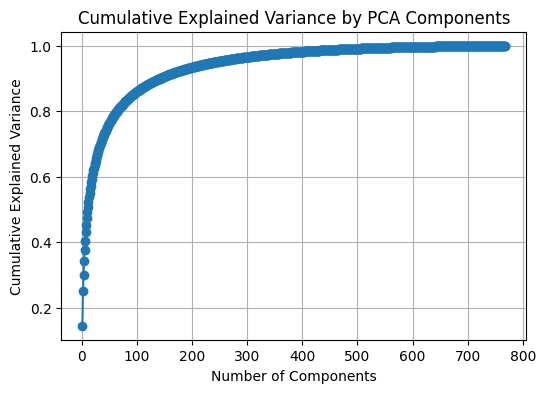

In [116]:
# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 执行 PCA
pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

# 绘制解释方差的累积图
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [117]:
# 确定降维结果
cumulative_variance = np.cumsum(explained_variance)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"累计解释方差达到 95% 时的主成分数量: {n_components_95}")

累计解释方差达到 95% 时的主成分数量: 242


In [118]:
pca = PCA(n_components=n_components_95)
X_reduced = pca.fit_transform(X_scaled)

# 将降维后的数据转换为 DataFrame
reduced_X = pd.DataFrame(X_reduced, columns=[f'problemPCA_{i}' for i in range(n_components_95)])

In [119]:
import pickle

with open('./IeltsScoring/scaler_model.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('./IeltsScoring/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [11]:
reduced_X.head()

,problemPCA_0,problemPCA_1,problemPCA_2,problemPCA_3,problemPCA_4,problemPCA_5,problemPCA_6,problemPCA_7,problemPCA_8,problemPCA_9,...,problemPCA_232,problemPCA_233,problemPCA_234,problemPCA_235,problemPCA_236,problemPCA_237,problemPCA_238,problemPCA_239,problemPCA_240,problemPCA_241
0,-17.232886,11.103489,2.556483,-6.696999,6.415413,-6.702465,-2.267281,2.999962,-3.213879,-11.053426,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
1,-17.232886,11.103489,2.556483,-6.696999,6.415413,-6.702465,-2.267281,2.999962,-3.213879,-11.053426,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
2,-17.232886,11.103489,2.556483,-6.696999,6.415413,-6.702465,-2.267281,2.999962,-3.213879,-11.053426,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
3,-17.232886,11.103489,2.556483,-6.696999,6.415413,-6.702465,-2.267281,2.999962,-3.213879,-11.053426,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
4,-17.232886,11.103489,2.556483,-6.696999,6.415413,-6.702465,-2.267281,2.999962,-3.213879,-11.053426,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456


In [10]:
reduced_X.to_csv("problemEB_pca.csv",index=False)

In [13]:
reduced_X = pd.read_csv("problemEB_pca.csv")

### 数据集合并 

In [5]:
df = pd.read_csv("data1028.csv")
df.head()

,problem,article,subParagraph,TR,CC,LR,GA,score,upper,spelling_errors,...,complex_simple_ratio,pronouns,cohesion,passive_ratio,modal_verbs_usage,Flesch_Kincaid_score,Gunning_Fog_score,SMOG_score,metaphor,grammar_error
0,Some children spend hours every day on their s...,"In contemporary society, it is a common sight ...",4,9.0,9.0,8.5,9.0,9.0,0,2,...,1.000000,10,1,0.583333,7,14.3,16.57,15.8,0,0
1,Some children spend hours every day on their s...,The ubiquitous presence of smartphones has pro...,5,9.0,9.0,8.5,9.0,9.0,0,2,...,0.941176,9,3,0.705882,10,13.3,15.27,14.8,1,0
2,Some children spend hours every day on their s...,The proliferation of pocket-sized electronics ...,5,9.0,9.0,9.0,9.0,9.0,0,5,...,1.000000,13,3,0.375000,5,15.8,17.56,17.1,2,0
3,Some children spend hours every day on their s...,The phenomenon of children spending extensive ...,5,9.0,9.0,9.0,9.0,9.0,0,4,...,0.894737,7,3,0.578947,6,14.2,16.69,16.0,0,0
4,Some children spend hours every day on their s...,"In the contemporary era, the proliferation of ...",5,7.0,7.0,8.0,8.0,7.5,0,2,...,0.823529,13,4,0.529412,4,15.6,16.50,16.6,0,0


In [34]:
cols = [False,False,True] + [False]*5 + [True] * (len(df.columns)-8)
X = df.loc[:,cols]
y = df.iloc[:,3:8]

In [ ]:
X = pd.concat([X, reduced_X, article2.iloc[:,:-1]], axis=1)
X['sim1'] = article1['sim']
X['sim2'] = article2['sim']
X['sim3'] = article3['sim']
X.head()

,subParagraph,upper,spelling_errors,tense_errors,plural_errors,simple,conjunctions,ccomp,acl,TTR,...,pooled_article_763,pooled_article_764,pooled_article_765,pooled_article_766,pooled_article_767,sim1,sim2,sim3,spelling_errors_auto,spelling_errors_min
0,4,0,2,0,0,4,9,5,2,0.526627,...,0.052485,-0.231286,-0.387914,0.132607,0.127587,0.592416,0.833845,0.742227,1,1
1,5,0,2,0,0,9,12,2,4,0.557276,...,0.091210,-0.098526,-0.379174,0.101284,0.296369,0.584839,0.805682,0.725340,3,2
2,5,0,5,0,0,5,8,3,2,0.553659,...,-0.020389,-0.336309,-0.249216,0.090952,0.409551,0.704020,0.812858,0.768589,4,4
3,5,0,4,0,0,9,12,1,3,0.556098,...,0.037428,-0.266677,-0.363386,0.069395,0.251479,0.602079,0.805791,0.796620,3,3
4,5,0,2,0,0,11,9,0,2,0.485488,...,-0.158340,-0.037632,-0.294965,0.042292,0.164457,0.536593,0.821881,0.682697,3,2


In [36]:
# 分数列存在少量异常值，修改为最接近的规范分数
def closest_score(value):
    """返回最接近的规范分数"""
    return min(valid_scores, key=lambda x: abs(x - value))

valid_scores = [round(i * 0.5, 1) for i in range(19)]

# 处理每个维度的分数
for column in y.columns[:4]:
    y[column] = y[column].apply(lambda x: closest_score(x) if x not in valid_scores else x)

y['score'] = y.mean(axis=1).apply(lambda x: closest_score(x))
y

,TR,CC,LR,GA,score
0,9.0,9.0,8.5,9.0,9.0
1,9.0,9.0,8.5,9.0,9.0
2,9.0,9.0,9.0,9.0,9.0
3,9.0,9.0,9.0,9.0,9.0
4,7.0,7.0,8.0,8.0,7.5
...,...,...,...,...,...
32234,6.0,6.0,5.0,5.0,5.5
32235,8.0,7.0,7.0,7.0,7.5
32236,6.0,5.0,5.0,5.0,5.5
32237,5.5,4.5,5.0,4.0,5.0


In [37]:
X.to_csv("X_1130.csv",index=False)
y.to_csv("y_1130.csv",index=False)

## 模型训练与调参

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import shap

In [5]:
X = pd.read_csv("X_1210.csv")
y = pd.read_csv("y_1130.csv")

In [6]:
X.head()

,subParagraph,upper,spelling_errors,spelling_errors_auto,spelling_errors_min,tense_errors,plural_errors,simple,conjunctions,ccomp,...,problemPCA_232,problemPCA_233,problemPCA_234,problemPCA_235,problemPCA_236,problemPCA_237,problemPCA_238,problemPCA_239,problemPCA_240,problemPCA_241
0,4,0,2,1,1,0,0,4,9,5,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
1,5,0,2,3,2,0,0,9,12,2,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
2,5,0,5,4,4,0,0,5,8,3,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
3,5,0,4,3,3,0,0,9,12,1,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456
4,5,0,2,3,2,0,0,11,9,0,...,-0.048014,-0.043541,0.047138,-0.052235,0.370582,0.437749,0.368619,-0.173555,-0.312778,-0.119456


In [41]:
new_columns = list(X.columns[:25])
new_columns += list(X.columns[-3:])
new_columns += list(X.columns[25:28])
new_columns += list(X.columns[28:-3])
len(new_columns)

1041

In [42]:
X = X[new_columns]

In [43]:
X.to_csv("X_1210.csv", index=False)

In [10]:
y1 = y['TR'] # 主题响应
y2 = y['CC'] # 衔接与连贯
y3 = y['LR'] # 词汇
y4 = y['GA'] #语法
score = y['score']

# 分割训练集和测试集
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test, y_train, y_test = train_test_split(
    X, y1, y2, y3, y4, score, test_size=0.2, random_state=77
)

In [7]:
cols1 = [True] * (len(X.columns)-242) + [False] * 242
X_less = X.loc[:,cols1]
X_less.head()

,subParagraph,upper,spelling_errors,spelling_errors_auto,spelling_errors_min,tense_errors,plural_errors,simple,conjunctions,ccomp,...,pooled_article_758,pooled_article_759,pooled_article_760,pooled_article_761,pooled_article_762,pooled_article_763,pooled_article_764,pooled_article_765,pooled_article_766,pooled_article_767
0,4,0,2,1,1,0,0,4,9,5,...,-0.095271,-0.120363,-0.034847,-0.385610,0.045610,0.052485,-0.231286,-0.387914,0.132607,0.127587
1,5,0,2,3,2,0,0,9,12,2,...,-0.057299,-0.120048,0.012121,-0.453344,-0.077796,0.091210,-0.098526,-0.379174,0.101284,0.296369
2,5,0,5,4,4,0,0,5,8,3,...,-0.072599,-0.073796,-0.143234,-0.323581,-0.062910,-0.020389,-0.336309,-0.249216,0.090952,0.409551
3,5,0,4,3,3,0,0,9,12,1,...,-0.002716,-0.013651,-0.177596,-0.371757,-0.112961,0.037428,-0.266677,-0.363386,0.069395,0.251479
4,5,0,2,3,2,0,0,11,9,0,...,-0.122347,0.045684,-0.046584,-0.428338,-0.034115,-0.158340,-0.037632,-0.294965,0.042292,0.164457


In [ ]:
# 分割训练集和测试集
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test, y_train, y_test = train_test_split(
    X_less, y1, y2, y3, y4, score, test_size=0.2, random_state=77
)

In [6]:
# 分割训练集和测试集
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test, y_train, y_test = train_test_split(
    X, y1, y2, y3, y4, score, test_size=0.1, random_state=77
)

X_train, X_valid, y1_train, y1_valid, y2_train, y2_valid, y3_train, y3_valid, y4_train, y4_valid, y_train, y_valid = train_test_split(
    X_train, y1_train, y2_train, y3_train, y4_train, y_train, test_size=0.2, random_state=77
)

### Bayes调参

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from bayes_opt import BayesianOptimization

# 定义目标函数
def xgb_evaluate(max_depth, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda):    
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

    xgb_model.fit(X_train, y1_train)

    y_pred = xgb_model.predict(X_test)
    test_mse = mean_squared_error(y1_test, [ielts_score(pred) for pred in y_pred])
    test_mae = mean_absolute_error(y1_test, [ielts_score(pred) for pred in y_pred])
    
    y_pred = xgb_model.predict(X_valid)
    mse = mean_squared_error(y2_valid, [ielts_score(pred) for pred in y_pred])
    mae = mean_absolute_error(y2_valid, [ielts_score(pred) for pred in y_pred])
    
    print("Valid MAE: ", mae, " Test MAE: ", test_mae)
    print("Valid MSE: ", mse, " Test MSE: ", test_mse)

    return -mse  

# 超参数搜索空间
pbounds = {
    'max_depth': (5, 10),
    'learning_rate': (0.02, 0.3),
    'n_estimators': (750, 1000),
    'subsample': (0.3, 1.0),
    'colsample_bytree': (0.3, 1.0),
    'reg_alpha': (0, 2),
    'reg_lambda': (0, 2)
}

optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=32
)
optimizer.maximize(init_points=10, n_iter=40)


|   iter    |  target   | n_esti... |
-------------------------------------
| 1         | -0.4234   | 971.8     |
| 2         | -0.4237   | 874.5     |
| 3         | -0.4227   | 911.0     |
| 4         | -0.4245   | 991.1     |
| 5         | -0.4232   | 947.3     |
| 6         | -0.424    | 963.2     |
| 7         | -0.4252   | 820.2     |
| 8         | -0.4237   | 985.7     |
| 9         | -0.4224   | 921.8     |
| 10        | -0.423    | 919.3     |
| 11        | -0.4225   | 925.4     |
| 12        | -0.4227   | 904.9     |
| 13        | -0.4227   | 897.0     |
| 14        | -0.423    | 889.4     |
| 15        | -0.4232   | 935.7     |
| 16        | -0.4239   | 849.7     |
| 17        | -0.4252   | 800.0     |
| 18        | -0.4232   | 862.6     |
| 19        | -0.4235   | 836.9     |
| 20        | -0.4235   | 882.9     |


In [ ]:
# 输出最优结果
print("Best parameters found: ", optimizer.max)
best_params = optimizer.max['params']
best_mse = -optimizer.max['target']

print("Best MSE: ", best_mse)

# 使用最优参数训练模型
xgb_model = XGBRegressor(
    #tree_method='gpu_hist',
    objective='reg:squarederror',
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42
)

# 读取数据
tmp = y.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, tmp, test_size=0.2, random_state=77) # 0:TR, 1:CC, 2:LR, 3:GA

xgb_model.fit(X_train, y_train)

# 训练集预测与评估
y_pred_train = xgb_model.predict(X_train)
mae_train = mean_absolute_error(y_train, [ielts_score(pred) for pred in y_pred_train])
mse_train = mean_squared_error(y_train, [ielts_score(pred) for pred in y_pred_train])
print("Train MSE: ", mse_train, " MAE: ", mae_train)

# 测试集预测与评估
y_pred_test = xgb_model.predict(X_test)
mae_test = mean_absolute_error(y_test, [ielts_score(pred) for pred in y_pred_test])
mse_test = mean_squared_error(y_test, [ielts_score(pred) for pred in y_pred_test])
print("Test MSE: ", mse_test, " MAE: ", mae_test)

Best parameters found:  {'target': -0.7559882819231432, 'params': {'colsample_bytree': 0.3035887357442316, 'learning_rate': 0.04475018504592673, 'max_depth': 6.432976285584298, 'n_estimators': 844.5406585367729, 'reg_alpha': 1.101131612896503, 'reg_lambda': 0.969566917657209, 'subsample': 0.9533345660207206}}
Best MSE:  0.7559882819231432
Train MSE:  0.13677251754487998  MAE:  0.22480710325307277
Test MSE:  0.7808622828784119  MAE:  0.6527605459057072


### XGBoost 回归预测

In [5]:
# 初始化 XGBoost 模型
xgb_params1 = {
    # 'tree_method': 'gpu_hist',
    'objective': 'reg:squarederror',   # 目标函数，回归任务
    'learning_rate': 0.043978,         # 学习率
    'max_depth': 6,                    # 树的最大深度
    'n_estimators': 921,               # 弱分类器的数量
    'subsample': 0.972919,             # 每棵树的随机样本比例
    'colsample_bytree': 0.152275,      # 每棵树的随机特征比例
    'reg_alpha': 3.540363,             # L1 正则化
    'reg_lambda': 0.1029225            # L2 正则化
}
xgb_params2 = {
    # 'tree_method': 'gpu_hist',
    'objective': 'reg:squarederror',   # 目标函数，回归任务
    'learning_rate': 0.05,             # 学习率
    'max_depth': 5,                    # 树的最大深度
    'n_estimators': 961,               # 弱分类器的数量
    'subsample': 1.0,                  # 每棵树的随机样本比例
    'colsample_bytree': 0.1,           # 每棵树的随机特征比例
    'reg_alpha': 2.032343,             # L1 正则化
    'reg_lambda': 1.992                # L2 正则化
}
xgb_params3 = {
    # 'tree_method': 'gpu_hist',
    'objective': 'reg:squarederror',  # 目标函数，回归任务
    'learning_rate': 0.0239,          # 学习率
    'max_depth': 7,                   # 树的最大深度
    'n_estimators': 864,              # 弱分类器的数量
    'subsample': 0.92593,             # 每棵树的随机样本比例
    'colsample_bytree': 0.3,          # 每棵树的随机特征比例
    'reg_alpha': 0.33562,             # L1 正则化
    'reg_lambda': 1.5471627           # L2 正则化
}
xgb_params4 = {
    # 'tree_method': 'gpu_hist',
    'objective': 'reg:squarederror',  # 目标函数，回归任务
    'learning_rate': 0.05,            # 学习率
    'max_depth': 6,                   # 树的最大深度
    'n_estimators': 953,              # 弱分类器的数量
    'subsample': 1.0,                 # 每棵树的随机样本比例
    'colsample_bytree': 0.36275,      # 每棵树的随机特征比例
    'reg_alpha': 3.83161,             # L1 正则化
    'reg_lambda': 0.336159            # L2 正则化
}

# 创建 XGBoost 回归模型
model1 = XGBRegressor(**xgb_params1)
model2 = XGBRegressor(**xgb_params2)
model3 = XGBRegressor(**xgb_params3)
model4 = XGBRegressor(**xgb_params4)

# 训练模型
model1.fit(X_train, y1_train)
model2.fit(X_train, y2_train)
model3.fit(X_train, y3_train)
model4.fit(X_train, y4_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.36275, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=953, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
# 评估模型性能
def ielts_score(prediction):
    if prediction < 0:
        return 0.0
    elif prediction > 9:
        return 9.0
    else:
        return round(prediction * 2) / 2  # 四舍五入到最近的0.5分

def evaluate(name, model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, [ielts_score(pred) for pred in y_train_pred])
    mse_test = mean_squared_error(y_test, [ielts_score(pred) for pred in y_test_pred])
    print(f"{name} - Train MSE: {mse_train:.2f}, Test MSE: {mse_test:.2f}")

    return y_train_pred, y_test_pred, [ielts_score(pred) for pred in y_train_pred], [ielts_score(pred) for pred in y_test_pred]

In [7]:
# 预测模型性能评价
pred1 = evaluate("TR", model1, X_train, X_test, y1_train, y1_test)
pred2 = evaluate("CC", model2, X_train, X_test, y2_train, y2_test)
pred3 = evaluate("LR", model3, X_train, X_test, y3_train, y3_test)
pred4 = evaluate("GA", model4, X_train, X_test, y4_train, y4_test)

''' 
10月：
TR - Train MSE: 0.16, Test MSE: 0.45
CC - Train MSE: 0.20, Test MSE: 0.59
LR - Train MSE: 0.19, Test MSE: 0.52
GA - Train MSE: 0.25, Test MSE: 0.79
Overall Score - Train MSE: 0.16, Test MSE: 0.45

11月：
TR - Train MSE: 0.15, Test MSE: 0.44
CC - Train MSE: 0.19, Test MSE: 0.57
LR - Train MSE: 0.18, Test MSE: 0.51
GA - Train MSE: 0.24, Test MSE: 0.76
Overall Score - Train MSE: 0.16, Test MSE: 0.43

12月：
TR - Train MSE: 0.01, Test MSE: 0.44
CC - Train MSE: 0.16, Test MSE: 0.56
LR - Train MSE: 0.08, Test MSE: 0.52
GA - Train MSE: 0.22, Test MSE: 0.76
Overall Score - Train MSE: 0.11, Test MSE: 0.42
'''

train_score = (np.array(pred1[2]) + np.array(pred2[2]) + np.array(pred3[2]) + np.array(pred4[2])) / 4
test_score = (np.array(pred1[3]) + np.array(pred2[3]) + np.array(pred3[3]) + np.array(pred4[3])) / 4

mse_train = mean_squared_error(y_train, [ielts_score(pred) for pred in train_score])
mse_test = mean_squared_error(y_test, [ielts_score(pred) for pred in test_score])
print(f"Overall Score - Train MSE: {mse_train:.2f}, Test MSE: {mse_test:.2f}")

TR - Train MSE: 0.10, Test MSE: 0.42
CC - Train MSE: 0.20, Test MSE: 0.55
LR - Train MSE: 0.09, Test MSE: 0.51
GA - Train MSE: 0.09, Test MSE: 0.76
Overall Score - Train MSE: 0.12, Test MSE: 0.42


In [8]:
# 存储训练好的模型
import pickle

with open('./IeltsScoring/model_tr.pkl', 'wb') as f:
    pickle.dump(model1, f)

with open('./IeltsScoring/model_cc.pkl', 'wb') as f:
    pickle.dump(model2, f)

with open('./IeltsScoring/model_lr.pkl', 'wb') as f:
    pickle.dump(model3, f)

with open('./IeltsScoring/model_ga.pkl', 'wb') as f:
    pickle.dump(model4, f)

### shap模型解释

In [9]:
with open('E:/vscode-L/PYTHON/NLP/IeltsScoring/model_lr.pkl', 'rb') as f:
    model3 = pickle.load(f)

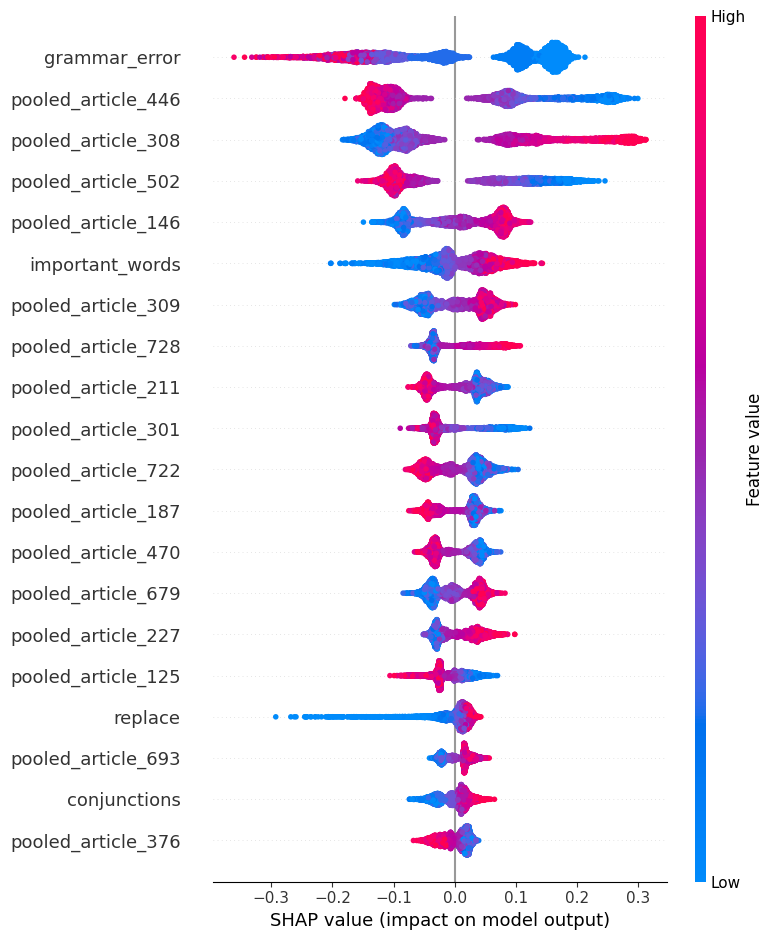

In [11]:
import shap

# 解析模型
explainer = shap.explainers.Tree(model3)
shap_values = explainer(X_test)

# 可视化
shap.summary_plot(shap_values, X_test)

In [12]:
y3_test.iloc[:20]

22056    5.5
22331    5.5
15451    4.5
32006    5.0
20374    5.5
10132    7.0
26530    4.0
8172     6.5
25360    5.0
4495     4.0
5996     8.0
3360     4.5
13494    5.0
22515    8.0
22763    4.5
21379    6.5
7156     5.5
10757    5.5
18350    7.0
30218    4.0
Name: LR, dtype: float64

In [84]:
fi = [(f,v) for f,v in zip(X.columns,shap_values[0].values) if 'problem' not in f and 'article' not in f]
fi.sort(key=lambda x: abs(x[1]), reverse=True)
fi

[('grammar_error', -0.3590226),
 ('spelling_errors_min', -0.11314786),
 ('longest_sentence', -0.03432017),
 ('important_words', -0.020770323),
 ('replace', 0.014433231),
 ('spelling_errors', -0.011286117),
 ('metaphor', -0.011164657),
 ('conjunctions', 0.008718479),
 ('spelling_errors_auto', -0.008177875),
 ('Flesch_Kincaid_score', 0.0077594984),
 ('sim1', -0.0071768737),
 ('sim3', 0.0068686116),
 ('TTR', -0.006109496),
 ('sim2', -0.005532683),
 ('passive_ratio', -0.005337215),
 ('complex_simple_ratio', 0.0026076296),
 ('avg_sentence_length', -0.002420228),
 ('subParagraph', 0.0024085958),
 ('acl', -0.0019327407),
 ('Gunning_Fog_score', 0.0017603355),
 ('simple', 0.0014500318),
 ('SMOG_score', 0.00070796296),
 ('pronouns', -0.00052127574),
 ('modal_verbs_usage', -0.000521189),
 ('shortest_sentence', -0.00043161778),
 ('advanced_words', 0.00013342666),
 ('ccomp', -0.00011854482),
 ('upper', -1.5434312e-05),
 ('cohesion', 1.1599007e-05),
 ('tense_errors', 0.0),
 ('plural_errors', 0.0)]

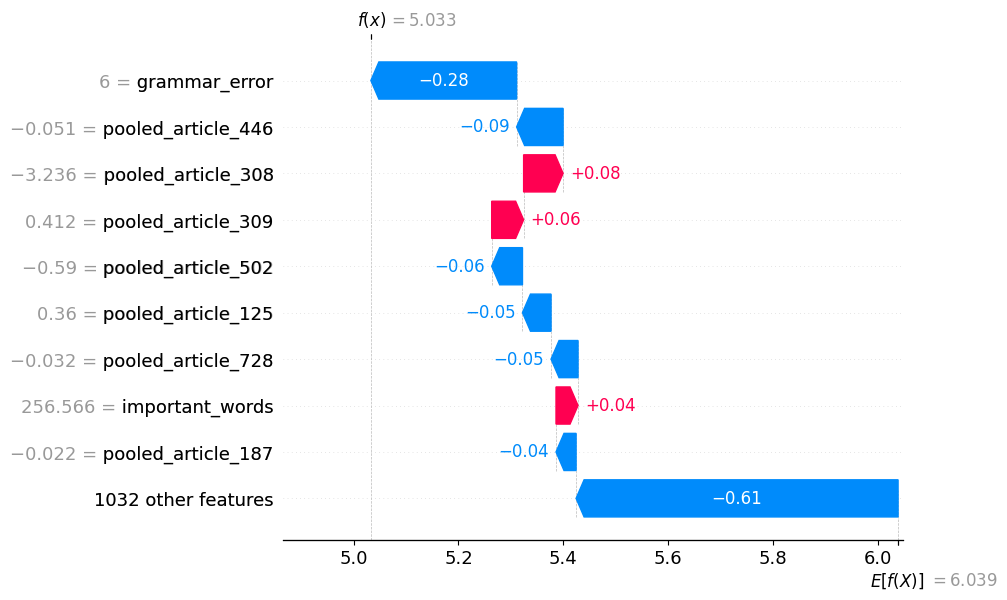

In [14]:
shap.plots.waterfall(shap_values[2])

In [85]:
# 分析模型预测情况
import matplotlib.pyplot as plt
import numpy as np

def pred_stats(y_true, y_pred, threshold=0.5):
    y_pred_tmp = [ielts_score(pred) for pred in y_pred]
    errors = np.abs(y_pred_tmp - y_true)

    # 绘制误差分布的直方图
    plt.hist(errors, bins=10, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Errors')
    plt.show()

    error_count = np.sum(errors > threshold)
    print(f"Number of samples with error > {threshold}: {error_count}, {error_count/len(y_pred)}")

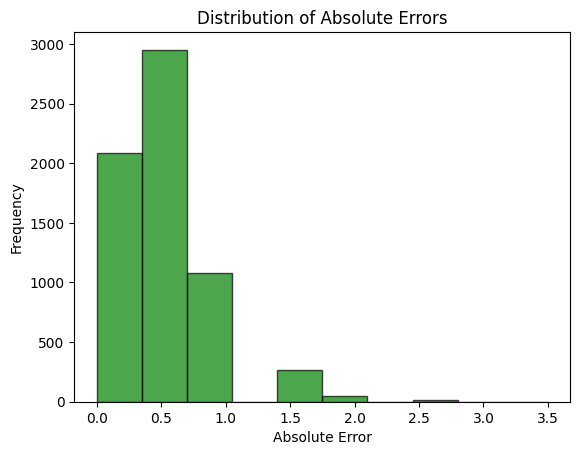

Number of samples with error > 0.5: 1412, 0.21898263027295287


In [87]:
# TR 0.5: 1408, 0.2130
# CC 0.5: 1900, 0.2874
# LR 0.5: 1716, 0.2596
# GA 0.5: 2237, 0.3384
pred_stats(y1_test, pred1[1], 0.5)

In [61]:
error = abs(y1_test-pred1[1])
error

28902    0.494649
29021    1.381182
10217    0.392572
14404    0.726095
30525    0.042370
           ...   
25527    0.369864
19333    0.333470
21075    0.281959
19316    0.126776
11951    1.098582
Name: TR, Length: 6610, dtype: float64

### XGBoost 分类器

In [32]:
y.describe()

,TR,CC,LR,GA,score
count,33047.000000,33047.000000,33047.000000,33047.000000,33047.000000
mean,6.504146,5.869852,6.050595,5.806563,6.132902
std,1.182884,1.463011,1.330339,1.601474,1.316740
min,3.000000,2.500000,0.000000,3.000000,4.000000
25%,5.500000,4.500000,5.000000,4.500000,5.000000
50%,6.500000,6.000000,6.000000,5.500000,6.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000
max,9.000000,9.000000,9.000000,9.000000,9.000000


In [26]:
def encode_ielts_scores(name, scores):
    """将雅思成绩编码为整数类别"""
    if name == 'TR':
        return np.array((scores - 3) * 2, dtype=int)
    elif name == 'CC':
        return np.array((scores - 2.5) * 2, dtype=int)
    elif name == 'LR':
        return np.maximum((scores - 2.5) * 2, 0).astype(int)
    elif name == 'GA':
        return np.array((scores - 3) * 2, dtype=int)
    else: # score
        return np.array((scores - 4) * 2, dtype=int)

def decode_ielts_scores(name, encoded_scores):
    """将编码的整数类别解码为雅思成绩"""
    if name == 'TR':
        return np.array(encoded_scores / 2 + 3, dtype=float)
    elif name == 'CC':
        return np.array(encoded_scores / 2 + 2.5, dtype=float)
    elif name == 'LR':
        ddict = {i:(i / 2 + 2.5) for i in range(1,14)}
        ddict[0] = 0
        return np.array([ddict[i] for i in encoded_scores], dtype=float)
    elif name == 'GA':
        return np.array(encoded_scores / 2 + 3, dtype=float)
    else: # score
        return np.array(encoded_scores / 2 + 4, dtype=float)

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 初始化 XGBoost 分类器模型
xgb_params = {
    'objective': 'multi:softmax',  # 目标函数，多类分类
    'learning_rate': 0.05,          # 学习率
    'max_depth': 5,                 # 树的最大深度
    'n_estimators': 300,            # 弱分类器的数量
    'subsample': 0.8,               # 每棵树的随机样本比例
    'colsample_bytree': 0.8,        # 每棵树的随机特征比例
    'reg_alpha': 0.5,               # L1 正则化
    'reg_lambda': 2.0,              # L2 正则化
    'random_state': 42              # 随机种子
}

# 创建 XGBoost 分类器模型
model1 = XGBClassifier(**xgb_params)
model2 = XGBClassifier(**xgb_params)
model3 = XGBClassifier(**xgb_params)
model4 = XGBClassifier(**xgb_params)

# 训练模型
model1.fit(X_train, encode_ielts_scores('TR',y1_train))
model2.fit(X_train, encode_ielts_scores('CC',y2_train))
model3.fit(X_train, encode_ielts_scores('LR',y3_train))
model4.fit(X_train, encode_ielts_scores('GA',y4_train))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [28]:
# 评估模型性能
def evaluate(name, model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 计算准确率
    accuracy_train = accuracy_score(encode_ielts_scores(name,y_train), y_train_pred)
    accuracy_test = accuracy_score(encode_ielts_scores(name,y_test), y_test_pred)
    # print(f"{name} - Train Accuracy: {accuracy_train:.2f}, Test Accuracy: {accuracy_test:.2f}")
    # print(classification_report(encode_ielts_scores(name,y_test), y_test_pred))  # 显示详细的分类报告
    
    # 评估预测情况
    mse_train = mean_squared_error(y_train, decode_ielts_scores(name,y_train_pred))
    mse_test = mean_squared_error(y_test, decode_ielts_scores(name,y_test_pred))
    print(f"{name} - Train MSE: {mse_train:.2f}, Test MSE: {mse_test:.2f}")

    return decode_ielts_scores(name,y_train_pred), decode_ielts_scores(name,y_test_pred)

pred1 = evaluate("TR", model1, X_train, X_test, y1_train, y1_test)
pred2 = evaluate("CC", model2, X_train, X_test, y2_train, y2_test)
pred3 = evaluate("LR", model3, X_train, X_test, y3_train, y3_test)
pred4 = evaluate("GA", model4, X_train, X_test, y4_train, y4_test)

train_score = (np.array(pred1[0]) + np.array(pred2[0]) + np.array(pred3[0]) + np.array(pred4[0])) / 4
test_score = (np.array(pred1[1]) + np.array(pred2[1]) + np.array(pred3[1]) + np.array(pred4[1])) / 4
mse_train = mean_squared_error(y_train, [ielts_score(pred) for pred in train_score])
mse_test = mean_squared_error(y_test, [ielts_score(pred) for pred in test_score])
print(f"Overall Score - Train MSE: {mse_train:.2f}, Test MSE: {mse_test:.2f}")

TR - Train MSE: 0.18, Test MSE: 0.55
CC - Train MSE: 0.19, Test MSE: 0.75
LR - Train MSE: 0.16, Test MSE: 0.65
GA - Train MSE: 0.25, Test MSE: 1.05
Overall Score - Train MSE: 0.15, Test MSE: 0.54


### Fintune Bert

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.utils.data import DataLoader
from torch.optim import AdamW
import time
from sklearn.metrics import mean_squared_error  # 用于计算回归任务的MSE
from transformers import BertTokenizer
from torch.utils.data import Dataset

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.bert = BertModel.from_pretrained('E:/vscode-L/PYTHON/NLP/bert-base-uncased/')
        
        # BERT模型微调
        for param in self.bert.parameters():
            param.requires_grad = True
        
        # 输出维度为4
        self.linear = nn.Linear(768, 4)

    def forward(self, x):
        input_ids, attention_mask = x[0].to(self.device), x[1].to(self.device)
        hidden_out = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=False)
        pred = self.linear(hidden_out.pooler_output)
        return pred

class MyDataset(Dataset):
    def __init__(self, texts, labels):
        self.all_text = texts
        self.all_label = labels
        self.max_len = 512
        self.tokenizer = BertTokenizer.from_pretrained('E:/vscode-L/PYTHON/NLP/bert-base-uncased/')

    def __getitem__(self, index):
        # 取出一条数据
        text = self.all_text.iloc[index][:self.max_len-2]
        label = self.all_label.iloc[index]

        # BERT tokenizer
        text_id = self.tokenizer.tokenize(text)
        text_id = ["[CLS]"] + text_id + ["[SEP]"]  # 添加 [CLS] 和 [SEP] 标记

        # 编码
        token_id = self.tokenizer.convert_tokens_to_ids(text_id)
        # 确保 token_ids 和 mask 长度为 self.max_len
        token_id = token_id[:self.max_len]
        mask = [1] * len(token_id) + [0] * (self.max_len - len(token_id))
        token_ids = token_id + [0] * (self.max_len - len(token_id))

        label = torch.tensor(label, dtype=torch.float32)
        token_ids = torch.tensor(token_ids)
        mask = torch.tensor(mask)

        return (token_ids, mask), label


    def __len__(self):
        return len(self.all_text)

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('E:\\vscode-L\\PYTHON\\NLP\\data1129.csv')

X_train, X_test, y_train, y_test = train_test_split(
    data['article'], data[['TR','CC','LR','GA']], test_size=0.2, random_state=77
)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_text, train_label = X_train, y_train

valid_text, valid_label = X_test, y_test

train_dataset = MyDataset(train_text, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = MyDataset(valid_text, valid_label)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


model = MyModel().to(device)

loss_fn = nn.MSELoss()

opt = AdamW(model.parameters(), lr=5e-4)

acc_max = float("-inf")
epoch = 20
start = time.time()

for epoch in range(epoch):
    loss_sum, count = 0, 0
    model.train()
    for batch_index, (batch_text, batch_label) in enumerate(train_dataloader):
        batch_label = batch_label.to(device)
        pred = model(batch_text)

        # 计算MSELoss
        loss = loss_fn(pred, batch_label)
        print(loss)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_sum += loss.item()  # 记录损失值
        count += 1

        if len(train_dataloader) - batch_index <= len(train_dataloader) % 1000 and count == len(train_dataloader) % 1000:
            msg = "[{0}/{1:5d}]\tTrain MSE:{2:.4f}"
            print(msg.format(epoch + 1, batch_index + 1, loss_sum / count))
            loss_sum, count = 0.0, 0

        if batch_index % 1000 == 999:
            msg = "[{0}/{1:5d}]\tTrain MSE:{2:.4f}"
            print(msg.format(epoch + 1, batch_index + 1, loss_sum / count))
            loss_sum, count = 0.0, 0

    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for batch_text, batch_label in valid_dataloader:
            batch_label = batch_label.to(device)
            pred = model(batch_text)

            # 获取预测结果
            pred = pred.cpu().numpy()
            label = batch_label.cpu().numpy()

            all_pred.extend(pred)
            all_true.extend(label)

    # 计算MSE
    mse = mean_squared_error(all_true, all_pred)
    print(f"Valid MSE: {mse:.4f}")

    # 保存最优模型
    if mse < acc_max:
        acc_max = mse
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saving the best model.")


end = time.time()
print(f"Running time: {(end - start) / 60:.4f} min")

''' 
best model: mse 1.98
'''